## Setup

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
from td.client import TDClient
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV,\
    cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier
# from code.functions import *
%matplotlib inline

In [51]:
pd.set_option('display.max_columns',None)

In [52]:
df = pd.read_csv('data/cmc.data', names = ['age','edu','hus_edu','chil','rel','work',
                                        'hus_ocu','sol','media','cmc'])

In [53]:
df

,age,edu,hus_edu,chil,rel,work,hus_ocu,sol,media,cmc
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0,3
1469,33,4,4,3,1,1,1,4,0,3
1470,39,3,3,8,1,0,1,4,0,3
1471,33,3,3,4,1,0,2,2,0,3


In [54]:
# sns.pairplot(df)

In [55]:
df.isna().sum()

age        0
edu        0
hus_edu    0
chil       0
rel        0
work       0
hus_ocu    0
sol        0
media      0
cmc        0
dtype: int64

In [56]:
df.cmc.value_counts()

1    629
3    511
2    333
Name: cmc, dtype: int64

Questions:  
ad spending or government spending on health education, to better target demographics who are not likely to use short or long-term contraceptive methods  
each row represents a person  
target variable is contraceptive method

# EDA

In [57]:
X = df.copy()
y = X.pop('cmc')

In [58]:
def feature_plot(df, ind, dep, plot_type, xlabel, xlog = 'n', ylog = 'n', color = u'#1f77b4'):
    ylabel = f'Contraception Method'
    title = f'{ylabel} vs {xlabel}'
    file_name = f'{xlabel}.png'
    fig, ax = plt.subplots(figsize = [12,8])
    if plot_type == 'scatter':
        sns_obj = sns.scatterplot(data = df, x=ind, y=dep, ax=ax, color = color)
    elif plot_type == 'line':
        sns_obj = sns.lineplot(data = df, x=ind, y=dep, color = color)
    if xlog == 'y':
        set_x_log(sns_obj, ax)
    if ylog == 'y':
        set_y_log(sns_obj, ax)
    # what color is u'#1f77b4'? what color is None?
    ax.set_title(title, fontdict = {'fontsize': 14})
    ax.set_xlabel(xlabel, fontdict = {'fontsize': 12})
    ax.set_ylabel(ylabel, fontdict = {'fontsize': 12})
    plt.savefig(f'visualizations/{file_name}')

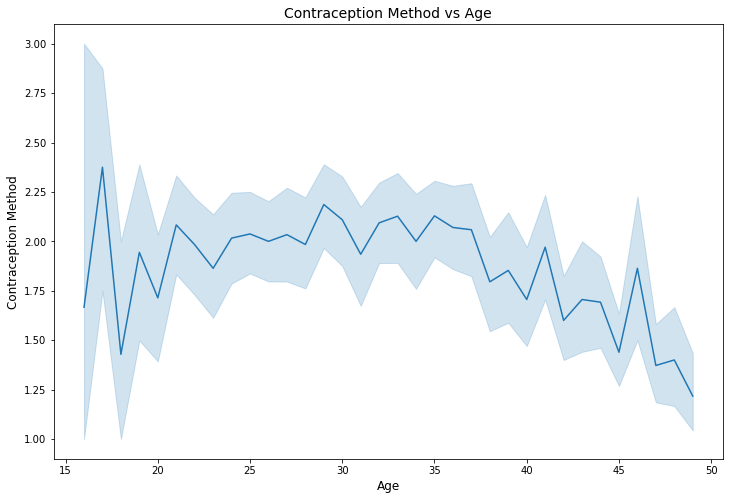

In [59]:
feature_plot(df, df.age, y, 'line', 'Age', xlog = 'n', ylog = 'n', color = u'#1f77b4')

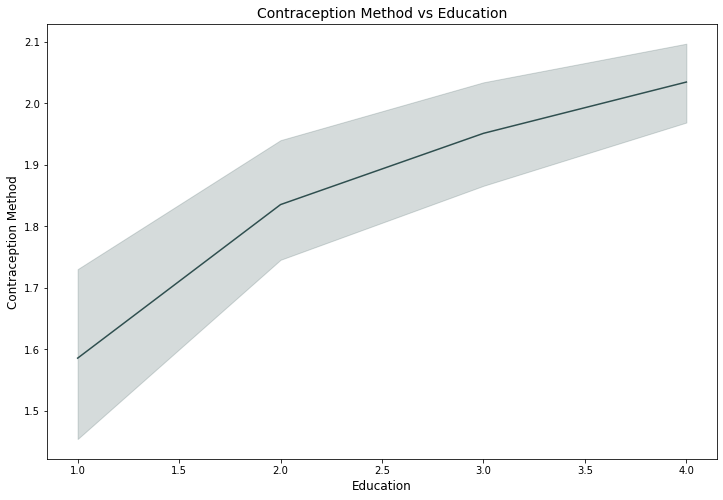

In [60]:
feature_plot(df, df.edu, y, 'line', 'Education', color = 'darkslategray')

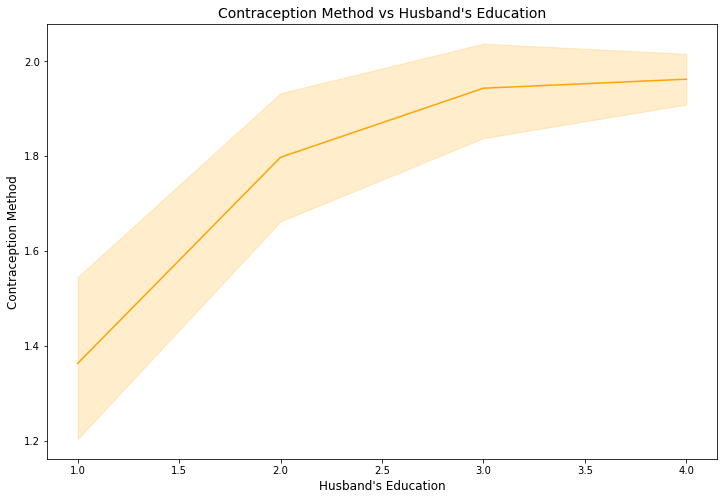

In [61]:
feature_plot(df, df.hus_edu, y, 'line', 'Husband\'s Education', color = 'orange')

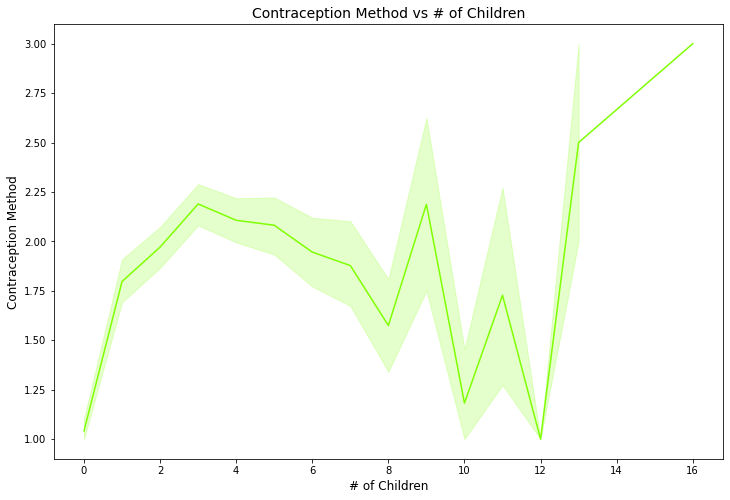

In [62]:
feature_plot(df, df.chil, y, 'line', '# of Children', color = 'chartreuse')

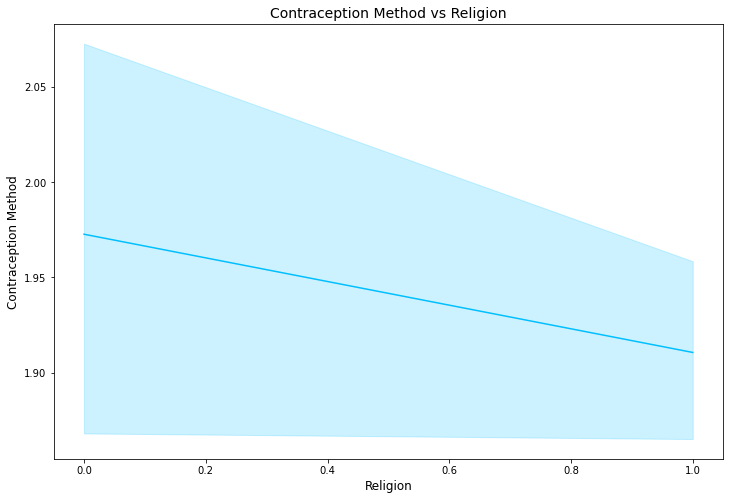

In [63]:
feature_plot(df, df.rel, y, 'line', 'Religion', color = 'deepskyblue')

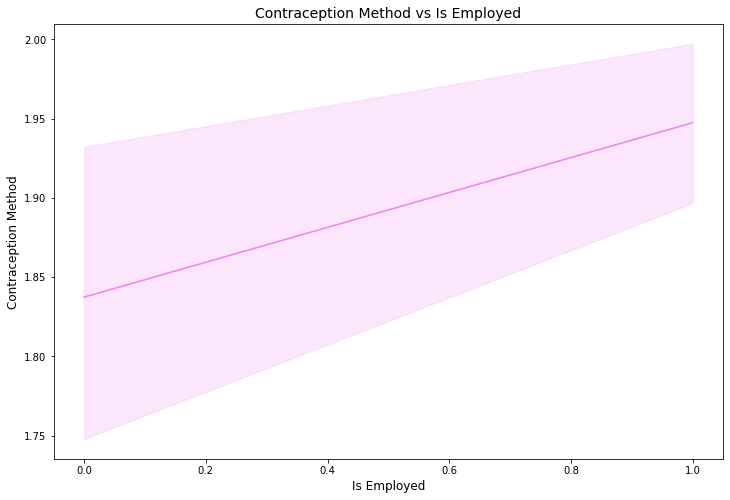

In [64]:
feature_plot(df, df.work, y, 'line', 'Is Employed', color = 'violet')

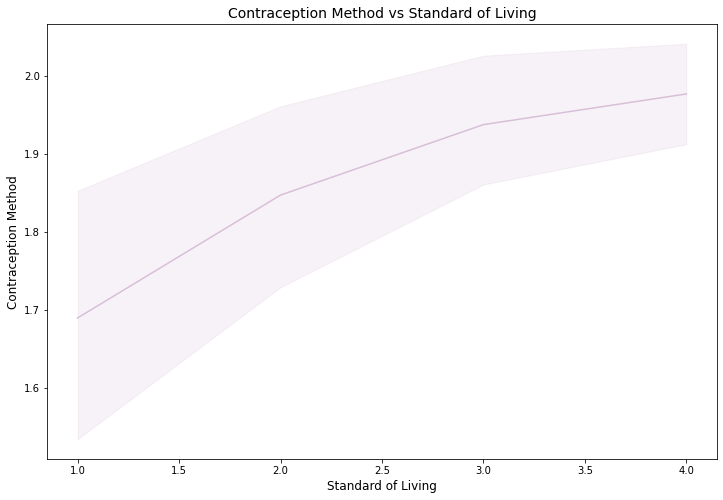

In [65]:
feature_plot(df, df.sol, y, 'line', 'Standard of Living', color = 'thistle')

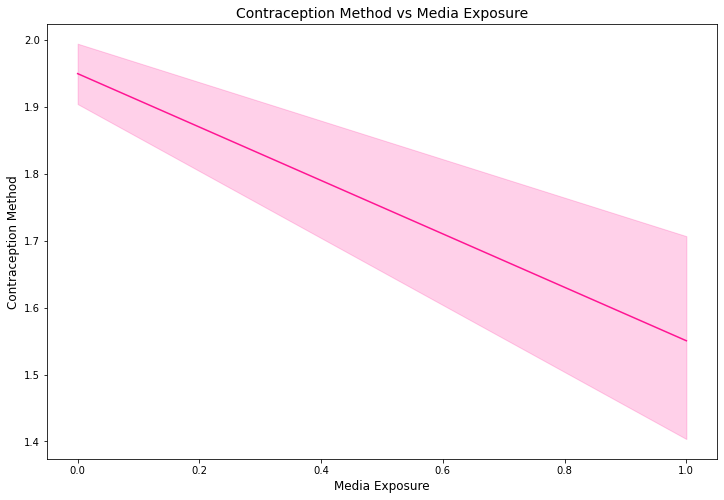

In [66]:
feature_plot(df, df.media, y, 'line', 'Media Exposure', color = 'deeppink')

In [67]:
# find menopause data for 1987

In [68]:
# hist, box, violin, bar
df

,age,edu,hus_edu,chil,rel,work,hus_ocu,sol,media,cmc
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0,3
1469,33,4,4,3,1,1,1,4,0,3
1470,39,3,3,8,1,0,1,4,0,3
1471,33,3,3,4,1,0,2,2,0,3


# Feature Engineering

## Dummying

In [69]:
to_dummy = ['edu', 'hus_edu', 'chil', 'hus_ocu', 'sol']
X_with_dums = pd.get_dummies(X, columns=to_dummy, drop_first=True)
# X_with_dums = pd.get_dummies(df, columns=to_dummy)
X_with_dums.shape

(1473, 30)

## Split data into train and test sets

In [80]:
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_with_dums, y, test_size=.25,
    random_state=1)
X_train.shape

(1104, 30)

## Scale features

In [81]:
rs = RobustScaler()

rs.fit(X_train)
X_train = rs.transform(X_train_df)
X_test = rs.transform(X_test_df)

## Label encode categorical variables - not working

In [72]:
# # ['age','edu','hus_edu','chil','rel','work', 'hus_ocu','sol','media','cmc'])
# label_encoder = LabelEncoder()
# mappings = []

# # 1 — did not go to school
# # 2 — some primary school
# # 3 — graduated from primary school with no further education
# # 4 — secondary or higher education

# # Desired label orders for categorical columns.
# edu_order = ['none', 'some_prim', 'prim', 'sec+']
# hus_edu_oder = ['none', 'some_prim', 'prim', 'sec+']

# # using cat.codes for order, one hot for high cardinality and weak case of cardinality.

# def ordered_labels(df, col, order):
#     df[col] = df[col].astype('category')
#     df[col] = df[col].cat.reorder_categories(order, ordered=True)
#     df[col] = df[col].cat.codes.astype(int)

# # Use dummy variables for husband occupation
# X = pd.concat([X, pd.get_dummies(X['hus_ocu'])],axis=1).drop('hus_ocu',axis=1)

# # Use ordered cat.codes for education, husband education
# ordered_labels(X, 'edu', edu_order)
# ordered_labels(X, 'hus_edu', hus_edu_oder)

# # Same label encoding for rest since low cardinality
# # for i, col in enumerate(X):
# #     if X_df[col].dtype == 'object':
# #         X_df[col] = label_encoder.fit_transform(np.array(X[col].astype(str)).reshape((-1,)))
# #         mappings.append(dict(zip(label_encoder.classes_, range(1, len(label_encoder.classes_)+1))))

# X.head()

In [73]:
# keep age continuous
# create new variable 18 or younger

# Modeling

## Functions

In [74]:
# def grid_search(model_type, X, y):
#     if model_type == log:
#         model = LogisticRegression()
#         params_grid = {
#             'multi_class': 'multinomial',
#             'solver': ['liblinear'],
#             'penalty': ['l1', 'l2'],
#             'C': np.logspace(-4, 4, 20),
#             'l1_ratio': stats.expon(scale=0.2),
#         }
#     elif model_type == dtc:
#         model = DecisionTreeClassifier()
#         params_grid = {
#             'criterion': ['gini', 'entropy'],
#             'max_depth': [None, 5, 3, 2],
#             'min_samples_split': [2, 10, 20]
#         }
#     elif model_type == knn:
#         model = KNeighborsClassifier()

#     gridsearch_model = GridSearchCV(estimator=model_type, param_grid=params_grid)

#     gridsearch_model.fit(X_train, y_train)
#     print(gridsearch_model.best_params_)
#     best_model = gridsearch_model.best_estimator_
#     best_model.score(X_test, y_test)

In [75]:
# def log_reg(X_train, X_test, y_train, y_test):
#     # Split data into train and test sets
# #     X_train, X_test, y_train, y_test = train_test_split(
# #         X, y, test_size=.25,
# #         random_state=1)
    
#     # Scale the data for modeling
# #     log_scaler = StandardScaler()
# #     log_scaler.fit(X_train)
# #     X_train_sc = log_scaler.transform(X_train)
# #     X_test_sc = log_scaler.transform(X_test)
    
#     # Train a logistic regression model with the train data
#     log_model = LogisticRegression(multi_class='multinomial', max_iter=1000
# #                                    solver='lbfgs'
# #                                    solver='liblinear',
# #                                    C=.001,
# #                                    class_weight = 'balanced'
#                                   )
#     log_model.fit(X_train, y_train)
# #     y_pred = log_model.predict(X_test)
# #     y_prob = log_model.predict_proba(X_test)
#     model_stats(X_train_df.columns, log_model, X_test, y_test)
#     return log_model

In [76]:
def model_stats(features, model, model_type, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    print('Classifier ', model_type)
    print('Num features: ', features.size)
    print('Model score: ', model.score(X_test, y_test))
    print('Accuracy score: ', accuracy_score(y_test, y_pred))
    print('Model F1 (micro): ', f1_score(y_test, y_pred, average='micro'))
    print('Model F1 (macro): ', f1_score(y_test, y_pred, average='macro'))
    print('Model F1 (weighted): ', f1_score(y_test, y_pred, average='weighted'))
    print('Cross validation score: ', cross_val_score(model, X_test, y_test, cv=5) )
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    fig, ax = plt.subplots(figsize = [6,8])
    plot_confusion_matrix(model, X_test, y_test, ax = ax)
#     plot_roc_curve(model, X_test_sc, y_test, ax = ax[1])
    macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
    weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                         average="weighted")
    macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                      average="macro")
    weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                         average="weighted")
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

def dummy_transform_scale(X, y, to_dummy, rs = 729):
    # to_dummy = ['edu', 'hus_edu', 'chil', 'hus_ocu', 'sol']
    X_with_dums = pd.get_dummies(X, columns=to_dummy, drop_first=True)
    # X_with_dums.shape
    X_train, X_test, y_train, y_test = train_test_split(
        X_with_dums, y, test_size = .25,
        random_state = rs)
    # X_train.shape
    rs = RobustScaler()
    rs.fit(X_train)
    X_train = rs.transform(X_train)
    X_test = rs.transform(X_test)
    return X_with_dums, X_train, X_test, y_train, y_test

## Logistic Regression - Base Model

Classifier  LogisticRegression
Num features:  30
Model score:  0.5718157181571816
Accuracy score:  0.5718157181571816
Model F1 (micro):  0.5718157181571816
Model F1 (macro):  0.5405777690559126
Model F1 (weighted):  0.5660858901627333
Cross validation score:  [0.60810811 0.51351351 0.58108108 0.48648649 0.53424658]
Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.69      0.68       161
           2       0.59      0.33      0.43        87
           3       0.46      0.59      0.52       121

    accuracy                           0.57       369
   macro avg       0.57      0.54      0.54       369
weighted avg       0.58      0.57      0.57       369

One-vs-One ROC AUC scores:
0.753569 (macro),
0.757098 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.759020 (macro),
0.760120 (weighted by prevalence)


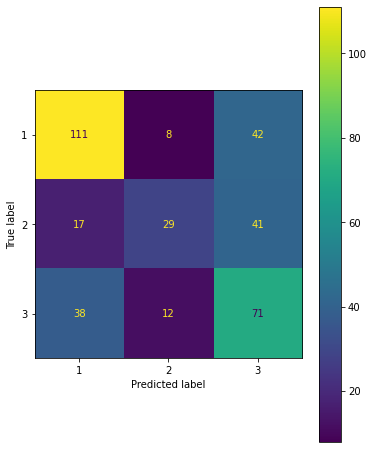

In [85]:
lr_base_clf = LogisticRegression(multi_class='multinomial', max_iter=1000
#                                    solver='lbfgs'
#                                    solver='liblinear',
#                                    C=.001,
#                                    class_weight = 'balanced'
                                  )
lr_base_clf.fit(X_train, y_train)
model_stats(X_train_df.columns, lr_base_clf, 'LogisticRegression', X_test, y_test)
# log_reg(X_train, X_test, y_train, y_test)

## LogisticRegression GridSearchCV

In [86]:
# set up pipeline
pipe_lr = Pipeline([('lr' , LogisticRegression(random_state=729, max_iter = 500))])

params_grid_lr = {# 'lr' : [LogisticRegression()],
                  'lr__penalty' : ['l1', 'l2', 'elasticnet'],
                  'lr__class_weight' : ['balanced', 'none'],
                  'lr__dual' : [True, False],
                  'lr__solver' : ['lbfgs', 'liblinear'],
                  'lr__C' : np.logspace(-4, 4, 20),
                  'lr__l1_ratio' : np.logspace(-4, 4, 20)
                 }

{'lr__C': 4.281332398719396, 'lr__class_weight': 'balanced', 'lr__dual': False, 'lr__l1_ratio': 0.0001, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Classifier  LogisticRegression
Num features:  30
Model score:  0.5663956639566395
Accuracy score:  0.5663956639566395
Model F1 (micro):  0.5663956639566395
Model F1 (macro):  0.5525960997138424
Model F1 (weighted):  0.5708900375324696
Cross validation score:  [0.56756757 0.51351351 0.55405405 0.56756757 0.53424658]
Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.61      0.66       161
           2       0.46      0.49      0.48        87
           3       0.50      0.56      0.53       121

    accuracy                           0.57       369
   macro avg       0.55      0.55      0.55       369
weighted avg       0.58      0.57      0.57       369

One-vs-One ROC AUC scores:
0.755294 (macro),
0.758796 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.760914 (macro),
0.

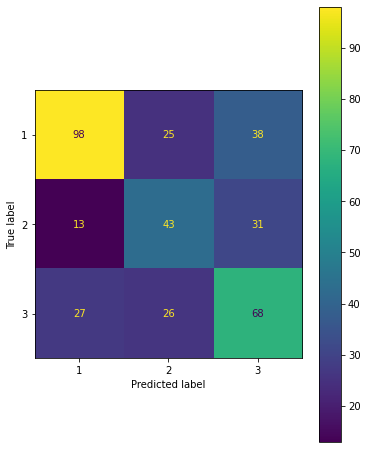

In [87]:
lr_clf = GridSearchCV(pipe_lr, param_grid = params_grid_lr, cv = 5, verbose=0, n_jobs=-1)

# fit on data
lr_clf.fit(X_train, y_train)
print(lr_clf.best_params_)
best_lr_clf = lr_clf.best_estimator_
model_stats(X_train_df.columns, best_lr_clf, 'LogisticRegression', X_test, y_test)

## RandomForestClassifier GridSearchCV

{'lr__C': 4.281332398719396, 'lr__class_weight': 'balanced', 'lr__dual': False, 'lr__l1_ratio': 0.0001, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Classifier  RandomForestClassifier
Num features:  30
Model score:  0.5663956639566395
Accuracy score:  0.5663956639566395
Model F1 (micro):  0.5663956639566395
Model F1 (macro):  0.5525960997138424
Model F1 (weighted):  0.5708900375324696
Cross validation score:  [0.56756757 0.51351351 0.55405405 0.56756757 0.53424658]
Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.61      0.66       161
           2       0.46      0.49      0.48        87
           3       0.50      0.56      0.53       121

    accuracy                           0.57       369
   macro avg       0.55      0.55      0.55       369
weighted avg       0.58      0.57      0.57       369

One-vs-One ROC AUC scores:
0.755294 (macro),
0.758796 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.760914 (macro)

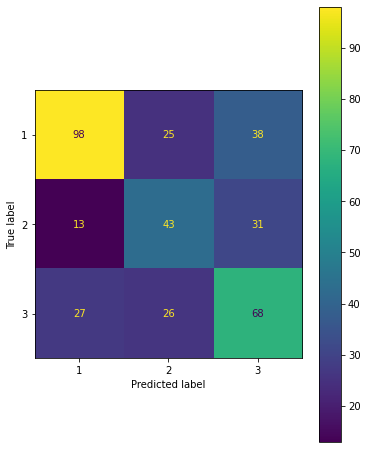

In [88]:
pipe_rfc = Pipeline([('rfc' , RandomForestClassifier())])

params_grid_rfc = {#'rfc' : [RandomForestClassifier()],
                   'rfc__n_estimators' : list(range(10,101,10)),
                   'rfc__max_features': ['auto', 'sqrt', 'log2'],
                   'rfc__max_depth' : list(range(1,10))
                  }

rfc_clf = GridSearchCV(pipe_rfc, param_grid = params_grid_rfc, cv = 5, verbose=0, n_jobs=-1)

rfc_clf.fit(X_train, y_train)
print(rfc_clf.best_params_)
best_rfc_clf = rfc_clf.best_estimator_
model_stats(X_train_df.columns, best_rfc_clf, 'RandomForestClassifier', X_test, y_test)

## LogisticRegression GridSearchCV with Tomek Links resampling

In [89]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train.ravel())
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 374, 3: 303, 2: 246})


{'lr__C': 1438.44988828766, 'lr__class_weight': 'balanced', 'lr__dual': False, 'lr__l1_ratio': 0.0001, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Classifier  LogisticRegression
Num features:  30
Model score:  0.5663956639566395
Accuracy score:  0.5663956639566395
Model F1 (micro):  0.5663956639566395
Model F1 (macro):  0.5525960997138424
Model F1 (weighted):  0.5708900375324696
Cross validation score:  [0.56756757 0.51351351 0.55405405 0.56756757 0.53424658]
Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.61      0.66       161
           2       0.46      0.49      0.48        87
           3       0.50      0.56      0.53       121

    accuracy                           0.57       369
   macro avg       0.55      0.55      0.55       369
weighted avg       0.58      0.57      0.57       369

One-vs-One ROC AUC scores:
0.755294 (macro),
0.758796 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.760914 (macro),
0.7

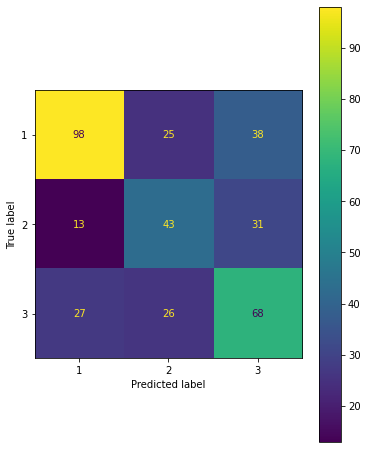

In [90]:
# Create grid search object
lr_tl_clf = GridSearchCV(pipe_lr, param_grid = params_grid_lr, cv = 5, verbose=0, n_jobs=-1)

# Fit on data
lr_tl_clf.fit(X_res, y_res)
print(lr_tl_clf.best_params_)
best_lr_tl_clf = lr_tl_clf.best_estimator_
model_stats(X_train_df.columns, best_lr_tl_clf, 'LogisticRegression', X_test, y_test)

## RandomForestClassifier GridSearchCV with Tomek Links resampling

{'rfc__max_depth': 9, 'rfc__max_features': 'sqrt', 'rfc__n_estimators': 80}
Classifier  RandomForestClassifier
Num features:  30
Model score:  0.5663956639566395
Accuracy score:  0.5663956639566395
Model F1 (micro):  0.5663956639566395
Model F1 (macro):  0.5525960997138424
Model F1 (weighted):  0.5708900375324696
Cross validation score:  [0.56756757 0.51351351 0.55405405 0.56756757 0.53424658]
Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.61      0.66       161
           2       0.46      0.49      0.48        87
           3       0.50      0.56      0.53       121

    accuracy                           0.57       369
   macro avg       0.55      0.55      0.55       369
weighted avg       0.58      0.57      0.57       369

One-vs-One ROC AUC scores:
0.755294 (macro),
0.758796 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.760914 (macro),
0.761401 (weighted by prevalence)


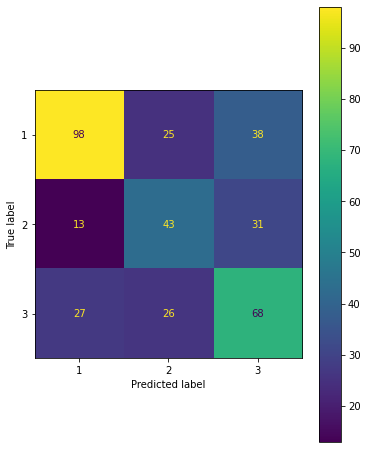

In [91]:
# Create grid search object
rfc_tl_clf = GridSearchCV(pipe_rfc, param_grid = params_grid_rfc, cv = 5, verbose=0, n_jobs=-1)

# Fit on data
rfc_tl_clf.fit(X_res, y_res)
print(rfc_tl_clf.best_params_)
best_rfc_tl_clf = rfc_tl_clf.best_estimator_
model_stats(X_train_df.columns, best_rfc_tl_clf, 'RandomForestClassifier', X_test, y_test)

## XGBoost with GridSearchCV

In [ ]:
pipe_xgb = Pipeline([('xgb', XGBClassifier(random_state=729, learning_rate = 0.2))])
params_grid_xgb = {'xgb__nthread': [4],  # not a stat
                   'xgb__booster' : ['gbtree', 'gblinear', 'dart'],
                   'xgb__colsample_bytree': [0.5, 0.7, 0.9],
                   'xgb__colsample_bylevel': [0.5, 0.7, 0.9],
                   'xgb__colsample_bynode': [0.5, 0.7, 0.9],
                   #'xgb__learning_rate': np.linspace(0.1, 0.2, 6), # does not need
                   'xgb__max_depth': [6, 8, 10],
                   'xgb__min_child_weight': [7,9,11,13,15],
                   'xgb__missing': [-999],
                   'xgb__n_estimators': [50, 100, 250, 500],
                   'xgb__objective': ['binary:logistic', 'reg:squarederror'],
                   'xgb__subsample': [0.2, 0.4, 0.6, 0.8]
                  }
xgb_clf = GridSearchCV(pipe_xgb, params_grid_xgb, n_jobs=-1,
                  cv=StratifiedKFold(n_splits=3, shuffle=True), 
                  scoring='roc_auc',
                  verbose=2, refit=True)
xgb_clf.fit(X_train, y_train)
print(xgb_clf.best_params_)
best_xgb_clf = xgb_clf.best_estimator_
model_stats(X_train_df.columns, best_xgb_clf, 'XGBClassifier', X_test, y_test)

Fitting 3 folds for each of 38880 candidates, totalling 116640 fits
